# Between Method Type Comparisons

This notebook compares across different methods, running them on the same set of simulations, and comparing the results. 

Time Domain methods that are compared:
- Autocorrelation decay rate
- Hurst exponent
- Detrended Fluctuation Analysis
- Higuchi Fractal Dimension
- Hjorth Complexity
- Lempel Ziv Complexity
- Sample Entropy
- Permutation Entropy

In addition, the above methods are compared to frequency domain methods:
- Spectral Parameterization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.analysis import compute_all_corrs, unpack_corrs
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_rows, plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS, COLORS
from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
                         lempelziv, sample_entropy, perm_entropy, specparam)
from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
                                  HJC_PARAMS, LZ_PARAMS, SA_ENT_PARAMS, PE_ENT_PARAMS)
from apm.sim.defs import SIM_SAMPLERS
from apm.utils import print_all_corrs

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Define settings
f_range = [1, 50]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : SIM_SAMPLERS.fs, 'f_range' : f_range}

In [6]:
# Settings for running comparisons
RETURN_SIM_PARAMS = True

In [7]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '42_between_comp'

## Collect Methods

In [8]:
# Update data specific settings
AC_DECAY_PARAMS['fs'] = SIM_SAMPLERS.fs
HURST_PARAMS['fs'] = SIM_SAMPLERS.fs
DFA_PARAMS['fs'] = SIM_SAMPLERS.fs

In [9]:
# Define measures to apply
measures = {
    autocorr_decay_time : AC_DECAY_PARAMS,
    hurst : HURST_PARAMS, 
    dfa : DFA_PARAMS,
    higuchi_fd : HFD_PARAMS,
    hjorth_complexity : HJC_PARAMS, 
    lempelziv : LZ_PARAMS,
    sample_entropy : SA_ENT_PARAMS,
    perm_entropy : PE_ENT_PARAMS,
    specparam : specparam_kwargs,
}

In [10]:
# Define measure listings
exp_measures = ['specparam']
drop_measures = ['hurst']

## Run Simulations

In [11]:
# Run simulations, comparing specparam exponent to entropy
results, all_sim_params = run_comparisons(\
    sim_combined, SIM_SAMPLERS['comb_sampler'], measures, return_sim_params=RETURN_SIM_PARAMS)

#### Correlations

In [12]:
# Compute correlations across all measures
all_corrs = compute_all_corrs(results)

In [13]:
# Compute correlations specific to with & without oscillations
all_corrs_osc = compute_all_corrs(results, all_sim_params['has_osc'].values)
all_corrs_no_osc = compute_all_corrs(results, ~all_sim_params['has_osc'].values)

#### Organize Outputs

In [14]:
# Get list of included time series measures & labels
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures + drop_measures];
ts_labels = [LABELS[meas] for meas in ts_measures]

In [15]:
# Subselect time domain measures from correlations
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures + drop_measures}
all_corrs_ts_osc = {ke : va for ke, va in all_corrs_osc.items() if ke not in exp_measures + drop_measures}
all_corrs_ts_no_osc = {ke : va for ke, va in all_corrs_no_osc.items() if ke not in exp_measures + drop_measures}

### Set up plotting things

In [16]:
# Collect colors for each value based on presence of an oscillation
colors = [COLORS['CM'] if osc else COLORS['AP'] for osc in all_sim_params.has_osc]

In [17]:
# Collect together info & plot settings 
dot_kwargs = {'s' : 25, 'c' : colors, 'alpha' : 0.25}

### Fluctuations to Complexity

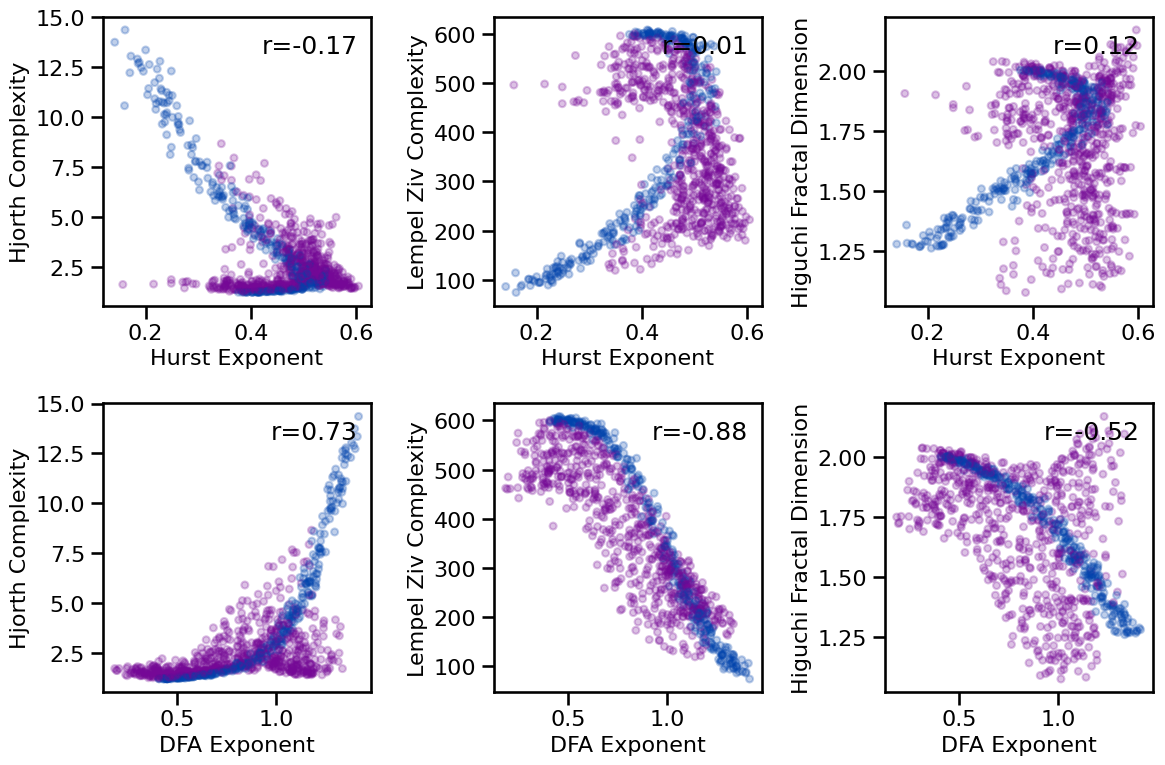

In [18]:
# Plot comparisons between fluctuation and complexity measures
plot_results_rows(results, ['hurst', 'dfa'],
                  ['hjorth_complexity', 'lempelziv', 'higuchi_fd'], **dot_kwargs,
                  save_fig=SAVE_FIG, file_name='fluc_compl_comp' + EXT, file_path=FIGPATH)

In [19]:
# Check correlations between fluctuations and complexity measures
print_all_corrs(all_corrs, ['hurst', 'dfa'],
                ['hjorth_complexity', 'lempelziv', 'higuchi_fd'])

Correlations:
  HE     & HJC   :   r=-0.166  CI[-0.237, -0.097],  p=0.000
  HE     & LZC   :   r=+0.005  CI[-0.069, +0.077],  p=0.873
  HE     & HFD   :   r=+0.121  CI[+0.051, +0.190],  p=0.000
  DFA    & HJC   :   r=+0.728  CI[+0.690, +0.761],  p=0.000
  DFA    & LZC   :   r=-0.880  CI[-0.891, -0.866],  p=0.000
  DFA    & HFD   :   r=-0.523  CI[-0.574, -0.470],  p=0.000


### Fluctuations to Entropy

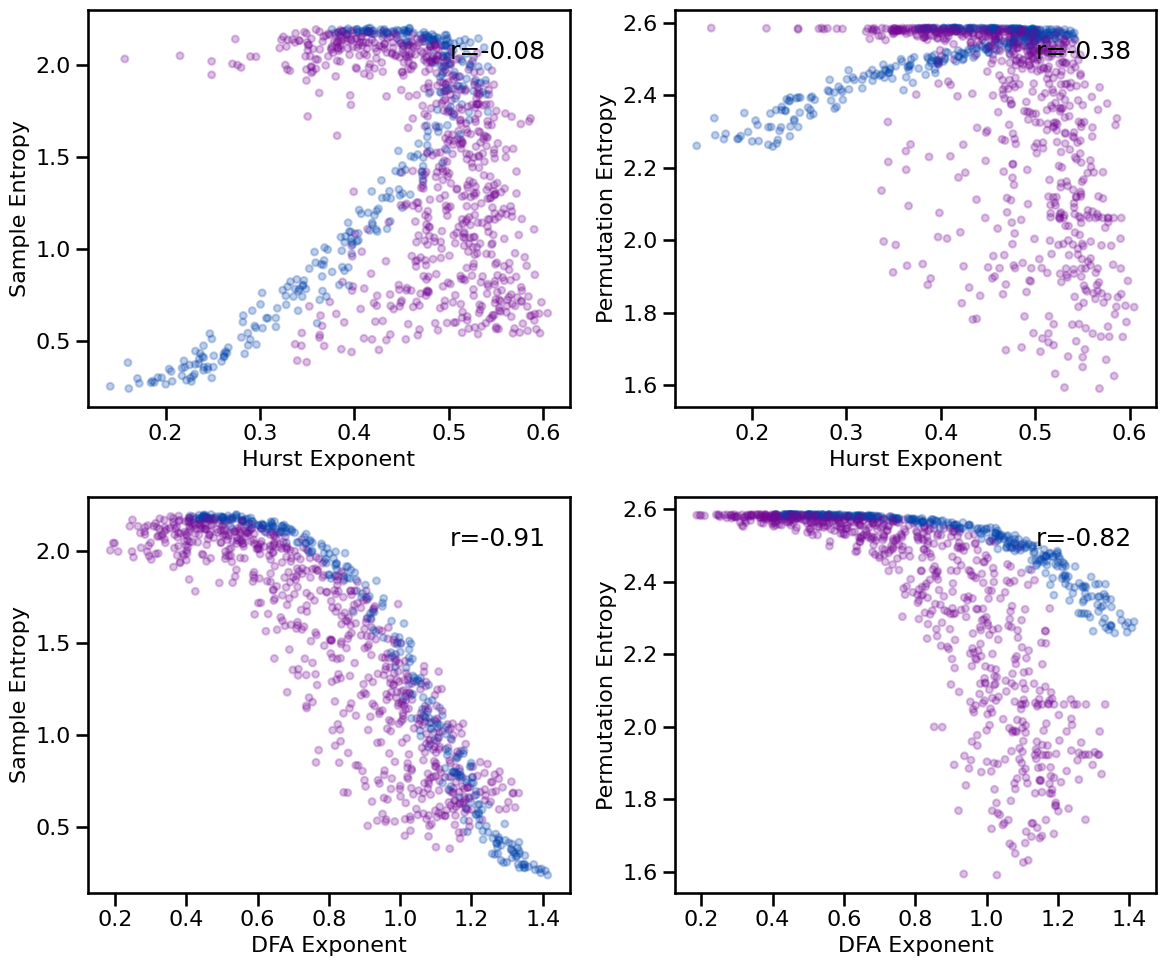

In [20]:
# Plot comparisons between fluctuation and entropy measures
plot_results_rows(results, ['hurst', 'dfa'], ['sample_entropy', 'perm_entropy'], 
                  **dot_kwargs, figsize=(12, 10),
                  save_fig=SAVE_FIG, file_name='info_fluc_comp' + EXT, file_path=FIGPATH)

In [21]:
# Check correlations between fluctuation and entropy measures
print_all_corrs(all_corrs, ['hurst', 'dfa'],
                ['sample_entropy', 'perm_entropy'])

Correlations:
  HE     & SampEn:   r=-0.077  CI[-0.152, -0.003],  p=0.015
  HE     & PeEn  :   r=-0.378  CI[-0.435, -0.318],  p=0.000
  DFA    & SampEn:   r=-0.911  CI[-0.919, -0.901],  p=0.000
  DFA    & PeEn  :   r=-0.819  CI[-0.833, -0.802],  p=0.000


### Complexity to Entropy

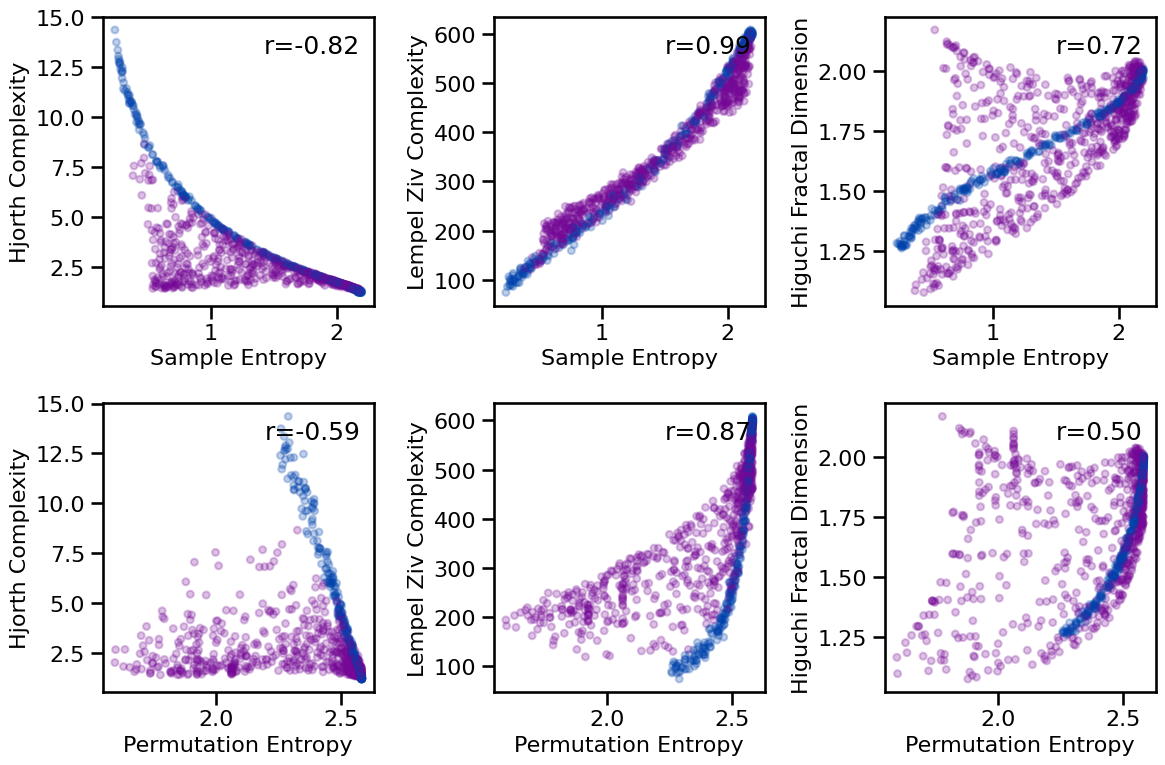

In [22]:
# Plot comparisons between complexity and entropy measures
plot_results_rows(results, ['sample_entropy', 'perm_entropy'],
                  ['hjorth_complexity', 'lempelziv', 'higuchi_fd'], **dot_kwargs,
                  save_fig=SAVE_FIG, file_name='compl_info_comp' + EXT, file_path=FIGPATH)

In [23]:
# Check correlations between entropy and complexity measures
print_all_corrs(all_corrs, ['sample_entropy', 'perm_entropy'],
                ['hjorth_complexity', 'lempelziv', 'higuchi_fd'])

Correlations:
  SampEn & HJC   :   r=-0.820  CI[-0.854, -0.783],  p=0.000
  SampEn & LZC   :   r=+0.986  CI[+0.982, +0.988],  p=0.000
  SampEn & HFD   :   r=+0.723  CI[+0.677, +0.767],  p=0.000
  PeEn   & HJC   :   r=-0.589  CI[-0.636, -0.539],  p=0.000
  PeEn   & LZC   :   r=+0.870  CI[+0.851, +0.886],  p=0.000
  PeEn   & HFD   :   r=+0.504  CI[+0.443, +0.563],  p=0.000


## Time Series - All

Compare time series methods to each other.

In [24]:
# Define set of measures to plot in group plot
measures = ['autocorr_decay_time', 'dfa', 'hjorth_complexity',
            'lempelziv', 'higuchi_fd', 'sample_entropy', 'perm_entropy']

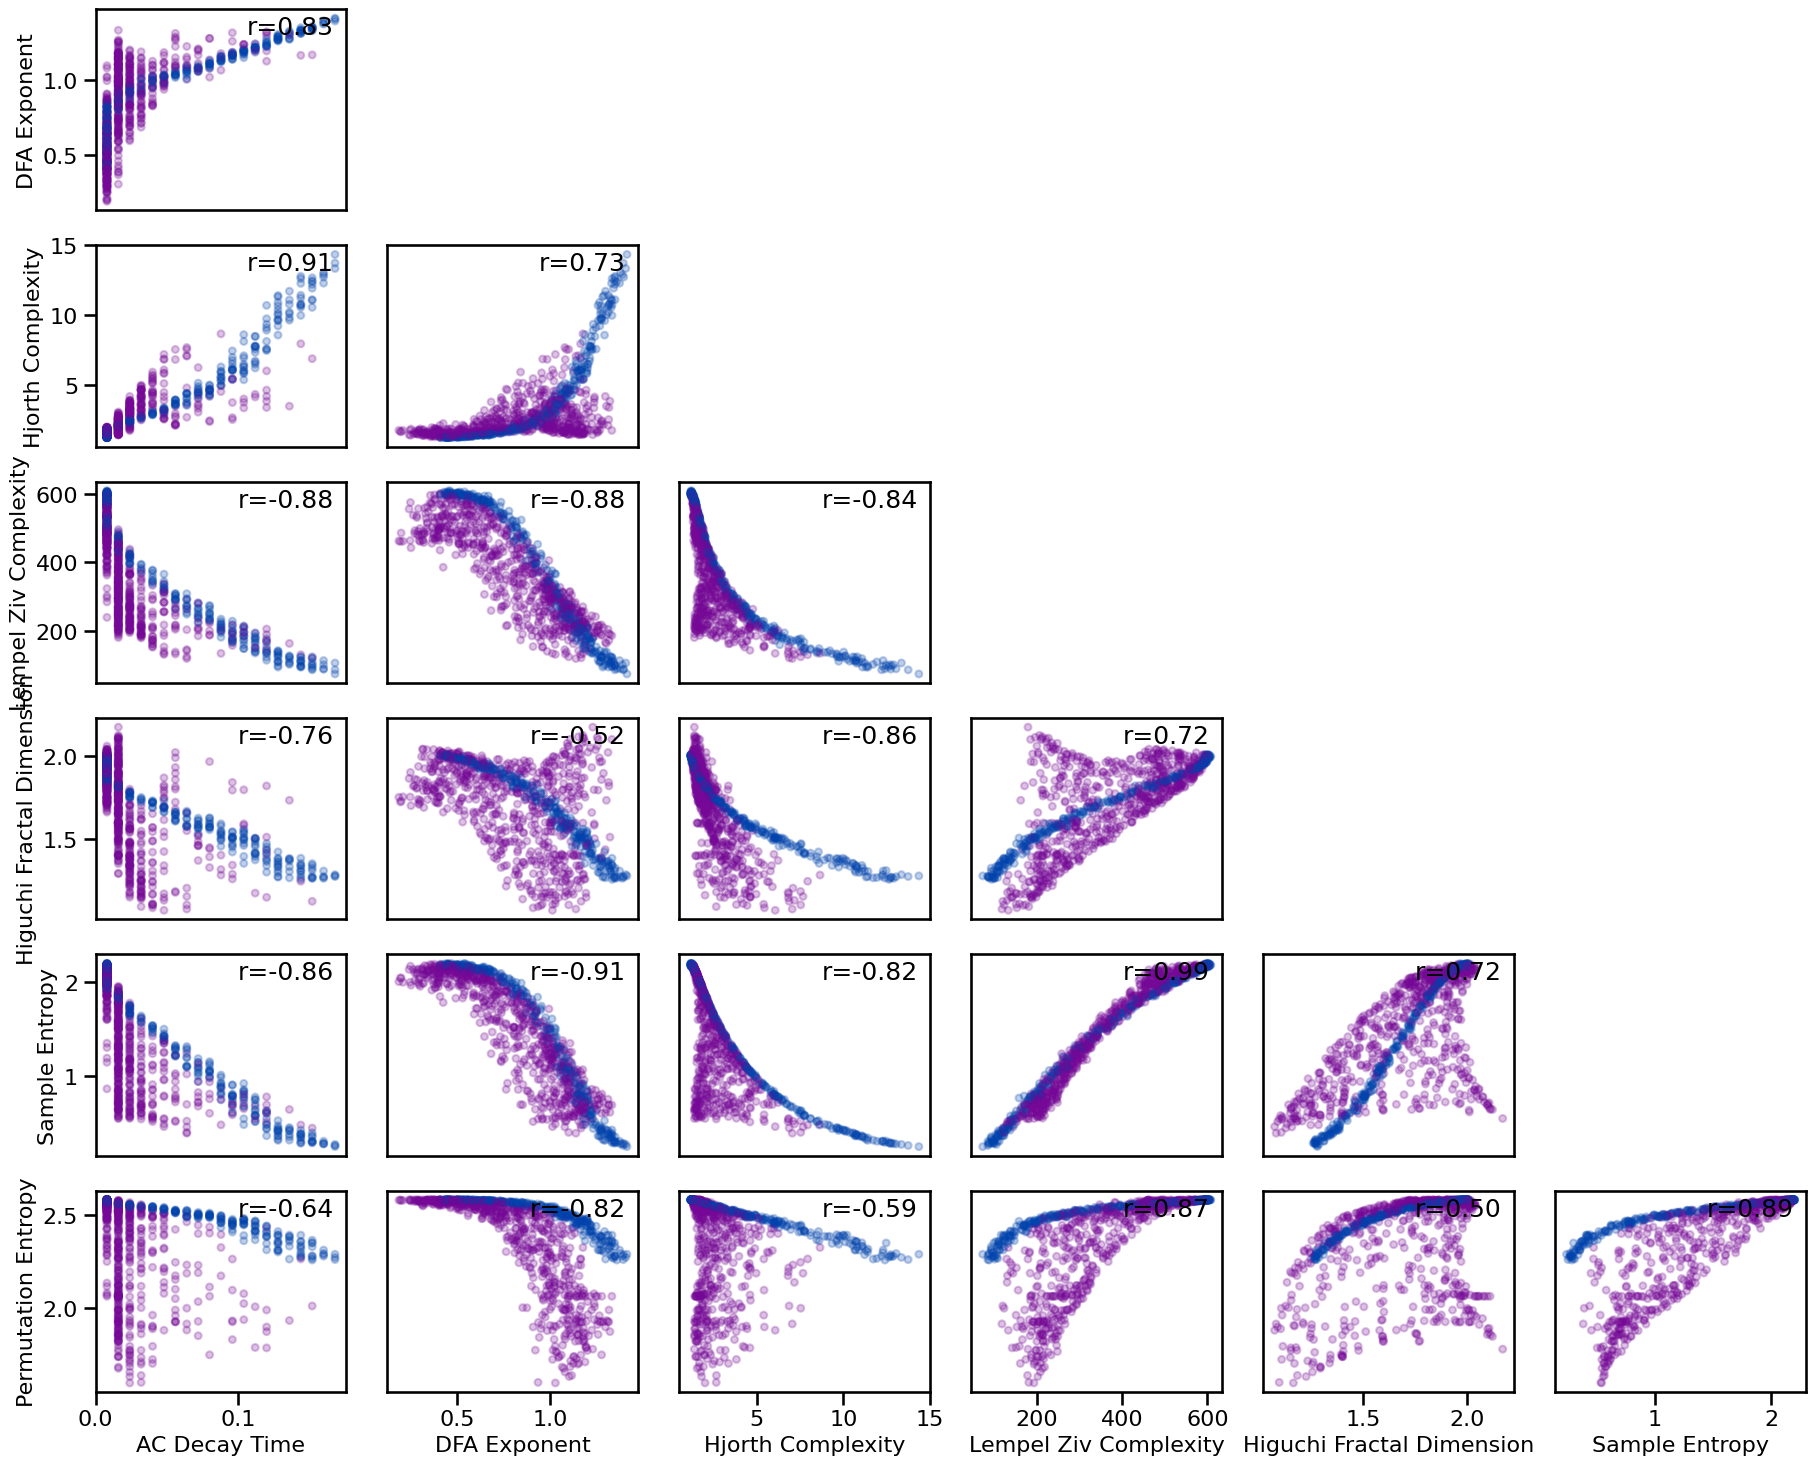

In [25]:
# Plot results across all measures
plot_results_all(results, measures, **dot_kwargs,
                 figsize=[18.5, 15], wspace=0.01, hspace=0.01)

#### Correlation Matrices

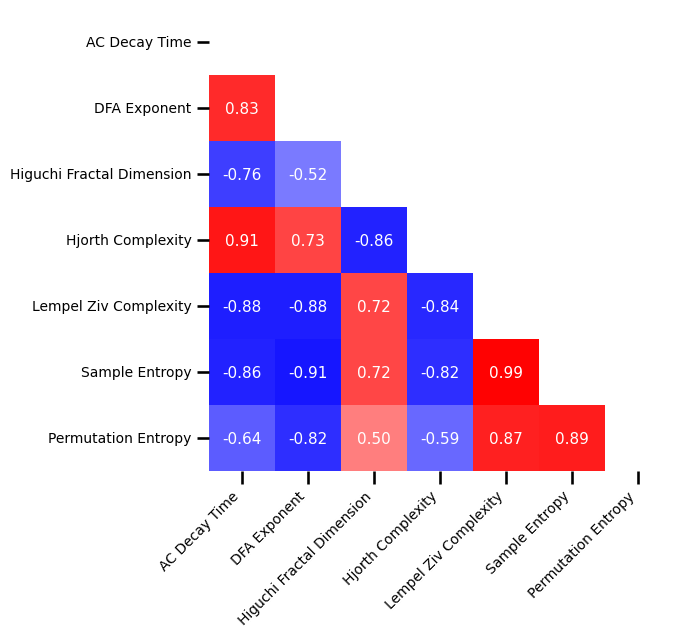

In [26]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(unpack_corrs(all_corrs_ts), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='corr_mat' + EXT, file_path=FIGPATH)

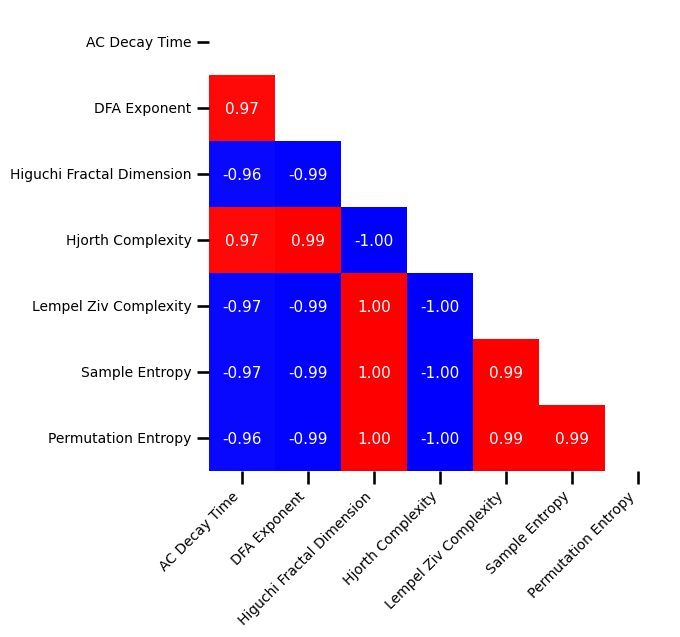

In [27]:
# Plot the correlations matrix across time series measures for no oscillation
plot_corr_matrix(unpack_corrs(all_corrs_ts_no_osc), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='corr_mat_no_osc' + EXT, file_path=FIGPATH)

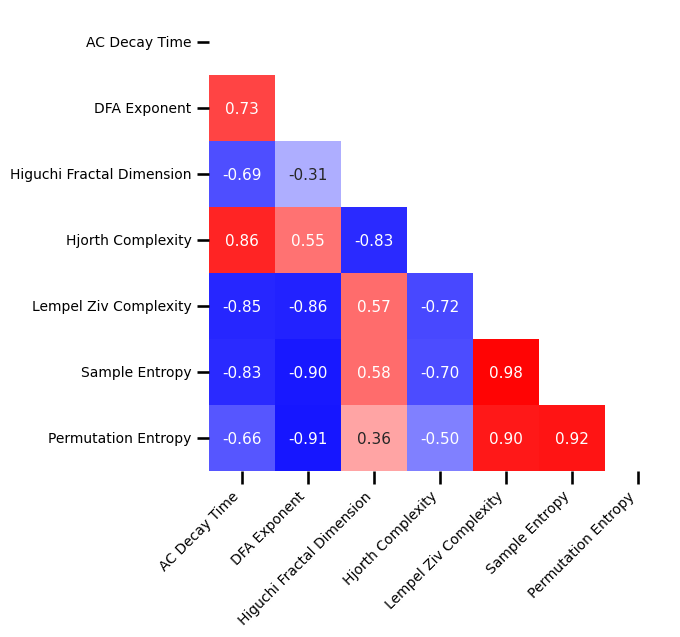

In [28]:
# Plot the correlations matrix across time series measures for with oscillation
plot_corr_matrix(unpack_corrs(all_corrs_ts_osc), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='corr_mat_osc' + EXT, file_path=FIGPATH)

## Exponent Comparisons

#### Exponent to Fluctuations

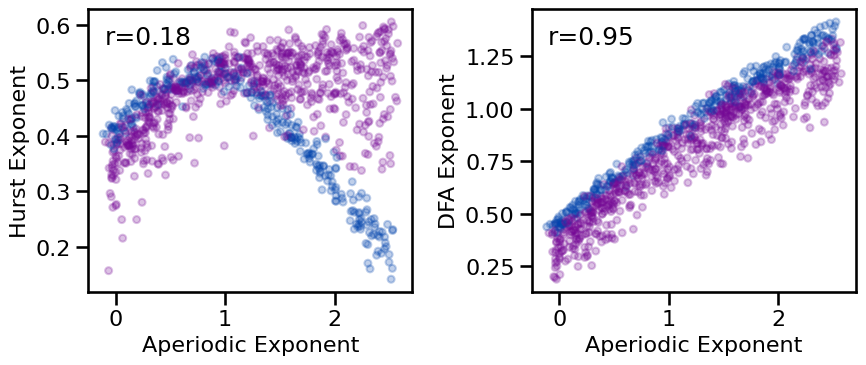

In [29]:
# Plot comparisons between exponent and fluctuation measures
plot_results_rows(results, ['specparam'], ['hurst', 'dfa'], **dot_kwargs, tposition='tl', figsize=(9, 4),
                  save_fig=SAVE_FIG, file_name='exp_fluc_comp' + EXT, file_path=FIGPATH)

In [30]:
# Check correlations between exponent and fluctuation measures
print_all_corrs(all_corrs, ['specparam'], ['hurst', 'dfa'])

Correlations:
  Exp(SP) & HE    :   r=+0.182  CI[+0.109, +0.256],  p=0.000
  Exp(SP) & DFA   :   r=+0.949  CI[+0.941, +0.954],  p=0.000


#### Exponent to Complexity

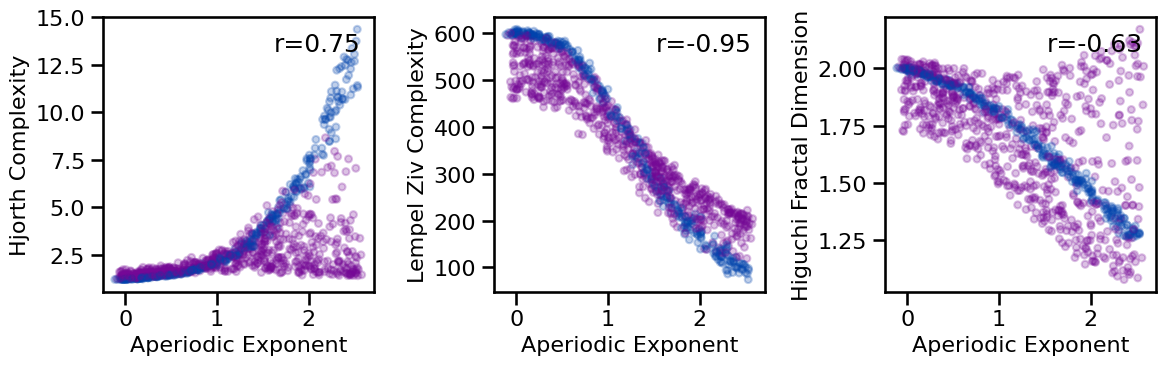

In [31]:
# Plot comparisons between exponent and fluctuation measures
plot_results_rows(results, ['specparam'], ['hjorth_complexity', 'lempelziv', 'higuchi_fd'],
                  **dot_kwargs, tposition='tr', figsize=(12, 4),
                  save_fig=SAVE_FIG, file_name='exp_compl_comp' + EXT, file_path=FIGPATH)

In [32]:
# Check correlations between exponent and complexity measures
print_all_corrs(all_corrs, ['specparam'], ['hjorth_complexity', 'lempelziv', 'higuchi_fd'])

Correlations:
  Exp(SP) & HJC   :   r=+0.749  CI[+0.706, +0.790],  p=0.000
  Exp(SP) & LZC   :   r=-0.947  CI[-0.953, -0.938],  p=0.000
  Exp(SP) & HFD   :   r=-0.634  CI[-0.686, -0.578],  p=0.000


#### Exponent to Entropy

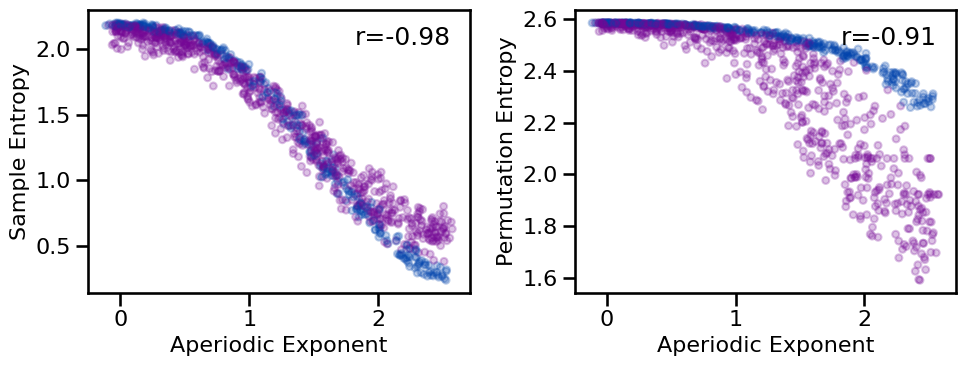

In [33]:
# Plot comparisons between exponent and entropy measures
plot_results_rows(results, ['specparam'], ['sample_entropy', 'perm_entropy'],
                  **dot_kwargs, tposition='tr', figsize=(10, 4),
                  save_fig=SAVE_FIG, file_name='exp_info_comp' + EXT, file_path=FIGPATH)

In [34]:
# Check correlations between exponent and entropy measures
print_all_corrs(all_corrs, ['specparam'], ['sample_entropy', 'perm_entropy'])

Correlations:
  Exp(SP) & SampEn:   r=-0.977  CI[-0.980, -0.973],  p=0.000
  Exp(SP) & PeEn  :   r=-0.909  CI[-0.918, -0.899],  p=0.000


#### Exponent to All

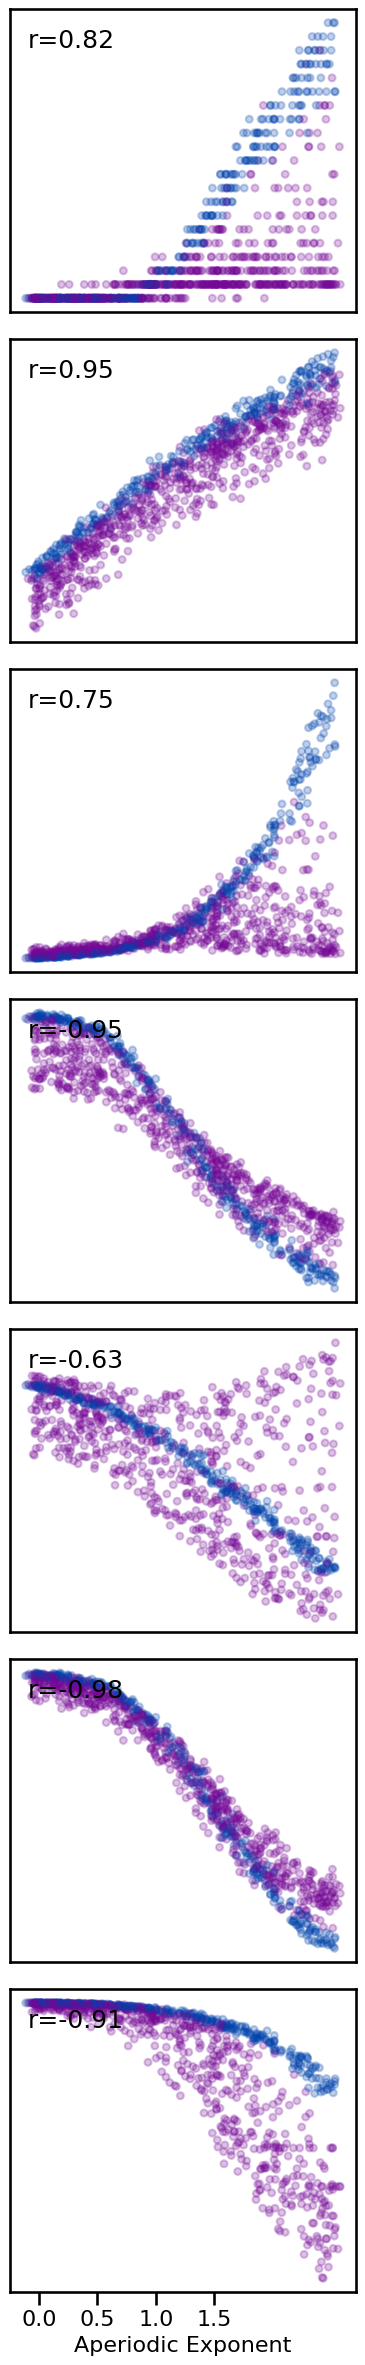

In [35]:
# Plot comparison of exponent to all other measures
axes = make_axes(7, 1, figsize=(4, 24), hspace=0.35)
for ind, meas in enumerate(measures):
    plot_dots(results['specparam'], results[meas],
              tposition='tl', yticks=[],
              xticks=[0.0, 0.5, 1.0, 1.5] if ind == 6 else [],
              xlabel='Aperiodic Exponent' if ind == 6 else '',
              **dot_kwargs, ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_comp' + EXT))

#### Correlation Matrices

In [36]:
# Extract the correlations between specparam and time domain measures
exp_corrs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T
exp_corrs_osc = np.atleast_2d([all_corrs_osc['specparam'][label][0] for label in ts_measures]).T
exp_corrs_no_osc = np.atleast_2d([all_corrs_no_osc['specparam'][label][0] for label in ts_measures]).T

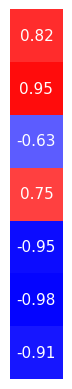

In [37]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs, cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_mat' + EXT, file_path=FIGPATH)

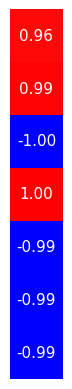

In [38]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_no_osc, cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_mat_no_osc' + EXT, file_path=FIGPATH)

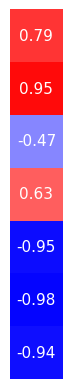

In [39]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_osc, cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_mat_osc' + EXT, file_path=FIGPATH)

## Conclusions

Comparing between time domain methods, overall we can see that:
- Fluctuation and complexity measures have varying, and generally non-linear, relationships to each other
- There is generally (though not exclusively) a positive correlation between entropy measures and complexity measures
- Entropy is generally negatively correlated to fluctuation measures, though the pattern is non-linear


Comparing time domain methods to exponent, overall we can see that:
- Hurst and DFA exponent generally increase with increasing aperiodic exponent
- Hjorth complexity increases, but lempel-ziv and higuchi fractal dimension decrease, with increasing exponent
- Entropy measures generally decrease with increasing exponent